In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from torch.distributions.categorical import Categorical
warnings.simplefilter("ignore")

## PPO Memory

In [3]:
class PPOMemory:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.clear()

    def update(self, state, action, value, prob, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.values.append(value)
        self.probs.append(prob)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear(self):
        self.states = []
        self.actions = []
        self.values = []
        self.probs = []
        self.rewards = []
        self.dones = []

    def generate_batches(self):
        arr = np.arange(0, len(self.rewards), self.batch_size)
        indices = np.arange(len(self.rewards), dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in arr]
        return np.array(self.states), np.array(self.actions), np.array(self.values), np.array(self.probs), np.array(self.rewards), np.array(self.dones), batches

## Actor Critic Networks

In [4]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, lr=1e-4, checkpoint_file="tmp/actor"):
        super(Actor, self).__init__()
        self.MLP = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        )
        self.checkpoint_file = checkpoint_file
        self.optimizer = torch.optim.Adam(params=self.MLP.parameters(),lr=lr)

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = Categorical(self.MLP(state))
        return dist

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [5]:
class Critic(nn.Module):
    def __init__(self, state_dim, lr=1e-4, checkpoint_file="tmp/critic"):
        super(Critic, self).__init__()
        self.MLP = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        self.checkpoint_file = checkpoint_file
        self.optimizer = torch.optim.Adam(params=self.MLP.parameters(),lr=lr)

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        return self.MLP(state)

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

## Agent

In [6]:
class Agent:
    def __init__(self, gamma, epsilon, gae_lambda, lr, epochs, state_dim, action_dim, batch_size):
        self.gamma = gamma
        self.epsilon = epsilon
        self.gae_lambda = gae_lambda
        self.lr = lr
        self.epochs = epochs
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size

        self.actor = Actor(state_dim, action_dim, lr)
        self.critic = Critic(state_dim, lr)
        self.memory = PPOMemory(batch_size)


    def choose_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.actor.device)
        dist = self.actor(state)
        
        action = dist.sample()
        prob = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()

        value = torch.squeeze(self.critic(state)).item()
        return action, value, prob

    def load_models(self):
        print("Loading models...")
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def save_models(self):
        print("Saving models...")
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def store_memory(self, state, action, value, prob, reward, done):
        self.memory.update(state, action, value, prob, reward, done)
        
    def clear_memory(self):
        self.memory.clear()

    def calculate_advantage(self, reward_arr, value_arr, dones_arr):
        #At = δt + (γλ)δt+1 + · · · + · · · + (γλ)T −t+1δT −1, (11)
        #where δt = rt + γV (st+1) − V (st)
        A = np.zeros(len(reward_arr), dtype=np.float32)
        T = len(reward_arr)
        for t in range(0, T-1):
            avg = 0
            discount = 1
            for k in range(t, T-1):
                r_t = reward_arr[k]
                V_t = value_arr[k]
                V_t_1 = 0 if dones_arr[k] or k==T-1 else value_arr[k+1]
                delta_t = r_t + self.gamma*V_t_1 - V_t
                #avg += discount*delta_t
                avg = (avg+delta_t)*discount # TODO: check if this is how it is done not the other.
                discount *= self.gae_lambda * self.gamma
            A[t] = avg
        return torch.tensor(A).to(agent.actor.device)

    def learn(self):
        for _ in range(self.epochs):
            states_arr, actions_arr, values_arr, probs_arr, rewards_arr, dones_arr, batches = self.memory.generate_batches()

            advantage_arr = self.calculate_advantage(rewards_arr, values_arr, dones_arr)
            values = torch.tensor(values_arr).to(self.actor.device)

            for batch in batches:
                states = torch.tensor(states_arr[batch]).to(self.actor.device)
                actions = torch.tensor(actions_arr[batch]).to(self.actor.device)
                old_probs = torch.tensor(probs_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = torch.squeeze(self.critic(states))

                
                new_probs = dist.log_prob(actions)
                #ratio = (new_probs - old_probs).exp()
                ratio = new_probs.exp() / old_probs.exp()
                weighted_ratio = ratio * advantage_arr[batch]
                clipped_ratio = torch.clamp(ratio, 1-self.epsilon, 1+self.epsilon) * advantage_arr[batch]
                actor_loss = -torch.min(weighted_ratio, clipped_ratio).mean()

                revenues = advantage_arr[batch] + values[batch]
                Lc = (revenues - critic_value)**2
                critic_loss = Lc.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
        self.clear_memory()

# Training

Saving models...
episode 0 score 15.0 avg score 15.0 time_steps 15 learning_steps 1
Saving models...
episode 1 score 18.0 avg score 16.5 time_steps 33 learning_steps 3
episode 2 score 12.0 avg score 15.0 time_steps 45 learning_steps 4
episode 3 score 10.0 avg score 13.8 time_steps 55 learning_steps 5
episode 4 score 14.0 avg score 13.8 time_steps 69 learning_steps 6
episode 5 score 12.0 avg score 13.5 time_steps 81 learning_steps 8
episode 6 score 15.0 avg score 13.7 time_steps 96 learning_steps 9
episode 7 score 11.0 avg score 13.4 time_steps 107 learning_steps 10
episode 8 score 18.0 avg score 13.9 time_steps 125 learning_steps 12
episode 9 score 10.0 avg score 13.5 time_steps 135 learning_steps 13
episode 10 score 15.0 avg score 13.6 time_steps 150 learning_steps 15
episode 11 score 11.0 avg score 13.4 time_steps 161 learning_steps 16
episode 12 score 11.0 avg score 13.2 time_steps 172 learning_steps 17
episode 13 score 11.0 avg score 13.1 time_steps 183 learning_steps 18
episode 14

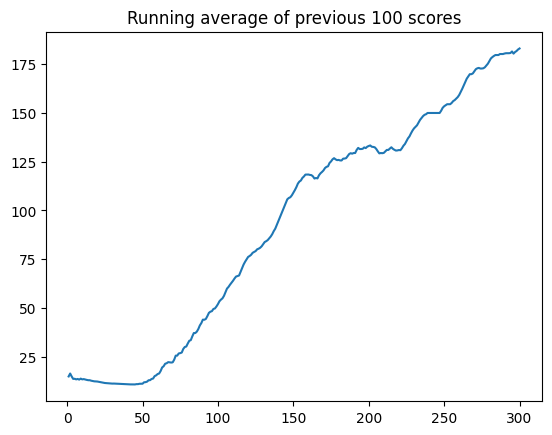

In [16]:
import gym
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
np.bool8 = np.bool


def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)


if not os.path.exists('tmp'):
    os.makedirs('tmp')


env = gym.make('CartPole-v0', render_mode='human')
N = 10 #20
batch_size = 5
n_epochs = 4
alpha = 0.0003 #0.0003
gamma=0.99
gae_lambda = 0.95
epsilon = 0.2


agent = Agent(gamma=gamma,
              epsilon=epsilon,
              gae_lambda=gae_lambda, 
              lr=alpha, 
              epochs=n_epochs, 
              state_dim=env.observation_space.shape[0], 
              action_dim=env.action_space.n, 
              batch_size=batch_size)

n_games = 300
figure_file = 'cartpole.png'
best_score = env.reward_range[0]
score_history = []
learn_iters = 0
avg_score = 0
n_steps = 0
for i in range(n_games):
    current_state,info = env.reset()
    terminated,truncated = False,False
    done = False
    score = 0
    while not done:
        action, val, prob = agent.choose_action(current_state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = 1 if (terminated or truncated) else 0
        n_steps += 1
        score += reward
        agent.store_memory(current_state, action, val, prob, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        current_state = next_state
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
    print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
            'time_steps', n_steps, 'learning_steps', learn_iters)
    
    
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)
env.close()

In [14]:
env.close()